In [1]:
import numpy as np

import random
from keras.datasets import mnist
from keras.models import Model
from keras.layers import Input, Flatten, Dense, Dropout, Lambda
from keras.optimizers import RMSprop
from keras import backend as K

Using TensorFlow backend.


In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
num_classes = 10
epochs = 10

In [4]:
def euclidean_distance(vects):
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))

def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

def contrastive_loss(y_true, y_pred):
    '''Contrastive loss from Hadsell-et-al.'06
    http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    '''
    margin = 1
    sqaure_pred = K.square(y_pred)
    margin_square = K.square(K.maximum(margin - y_pred, 0))
    return K.mean(y_true * sqaure_pred + (1 - y_true) * margin_square)

In [5]:
def create_pairs(x, digit_indices):
    '''Positive and negative pair creation.
    Alternates between positive and negative pairs.
    '''
    pairs = []
    labels = []
    n = min([len(digit_indices[d]) for d in range(num_classes)]) - 1
    for d in range(num_classes):
        for i in range(n):
            z1, z2 = digit_indices[d][i], digit_indices[d][i + 1]
            pairs += [[x[z1], x[z2]]]
            inc = random.randrange(1, num_classes)
            dn = (d + inc) % num_classes
            z1, z2 = digit_indices[d][i], digit_indices[dn][i]
            pairs += [[x[z1], x[z2]]]
            labels += [1, 0]
    return np.array(pairs), np.array(labels)

In [6]:
def create_base_network(input_shape):
    '''Base network to be shared (eq. to feature extraction).
    '''
    input = Input(shape=input_shape)
    x = Flatten()(input)
    x = Dense(128, activation='linear')(x)
    x = Dropout(0.3)(x)
    x = Dense(128, activation='linear')(x)
    x = Dropout(0.3)(x)
    x = Dense(2, activation='linear')(x)
    return Model(input, x)

In [7]:
def compute_accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    pred = y_pred.ravel() < 0.5
    return np.mean(pred == y_true)


def accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    return K.mean(K.equal(y_true, K.cast(y_pred < 0.5, y_true.dtype)))

In [8]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
input_shape = x_train.shape[1:]

In [9]:
digit_indices = [np.where(y_train == i)[0] for i in range(num_classes)]
tr_pairs, tr_y = create_pairs(x_train, digit_indices)

digit_indices = [np.where(y_test == i)[0] for i in range(num_classes)]
te_pairs, te_y = create_pairs(x_test, digit_indices)

# network definition
base_network = create_base_network(input_shape)

input_a = Input(shape=input_shape)
input_b = Input(shape=input_shape)

In [10]:
processed_a = base_network(input_a)
processed_b = base_network(input_b)

distance = Lambda(euclidean_distance,
                  output_shape=eucl_dist_output_shape)([processed_a, processed_b])

model = Model([input_a, input_b], distance)

In [11]:
rms = RMSprop()
model.compile(loss=contrastive_loss, optimizer=rms, metrics=[accuracy])
model.fit([tr_pairs[:, 0], tr_pairs[:, 1]], tr_y,
          batch_size=128,
          epochs=epochs,
validation_data=([te_pairs[:, 0], te_pairs[:, 1]], te_y))

Train on 108400 samples, validate on 17820 samples
Epoch 1/10
108400/108400 [==============================] - 3s 28us/step - loss: 0.2232 - accuracy: 0.6840 - val_loss: 0.1535 - val_accuracy: 0.7856
Epoch 2/10
108400/108400 [==============================] - 2s 22us/step - loss: 0.1647 - accuracy: 0.7673 - val_loss: 0.1452 - val_accuracy: 0.7990
Epoch 3/10
108400/108400 [==============================] - 2s 22us/step - loss: 0.1633 - accuracy: 0.7697 - val_loss: 0.1486 - val_accuracy: 0.7973
Epoch 4/10
108400/108400 [==============================] - 2s 22us/step - loss: 0.1625 - accuracy: 0.7702 - val_loss: 0.1449 - val_accuracy: 0.8002
Epoch 5/10
108400/108400 [==============================] - 2s 22us/step - loss: 0.1621 - accuracy: 0.7710 - val_loss: 0.1467 - val_accuracy: 0.7985
Epoch 6/10
108400/108400 [==============================] - 2s 22us/step - loss: 0.1620 - accuracy: 0.7725 - val_loss: 0.1464 - val_accuracy: 0.8010
Epoch 7/10
108400/108400 [=============================

In [12]:
# compute final accuracy on training and test sets
y_pred = model.predict([tr_pairs[:, 0], tr_pairs[:, 1]])
tr_acc = compute_accuracy(tr_y, y_pred)
y_pred = model.predict([te_pairs[:, 0], te_pairs[:, 1]])
te_acc = compute_accuracy(te_y, y_pred)

In [13]:
print('* Accuracy on training set: %0.2f%%' % (100 * tr_acc))
print('* Accuracy on test set: %0.2f%%' % (100 * te_acc))

* Accuracy on training set: 78.54%
* Accuracy on test set: 79.38%


In [14]:
get_all_layer_outputs = K.function([base_network.layers[0].input],
                                  [l.output for l in base_network.layers[1:]])

In [15]:
layer_output = get_all_layer_outputs([x_test])

In [16]:
numbers_embeddings = layer_output[5]

In [17]:
from sklearn.manifold import TSNE

In [18]:
tsne = TSNE(n_components=2, verbose=1, perplexity=100, n_iter=500)

In [19]:
vis_x_train = x_train.reshape(x_train.shape[0], 784)
vis_x_test = x_test.reshape(x_test.shape[0], 784)

In [20]:
tsne_result = tsne.fit_transform(vis_x_test[:5000])

[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.105s...
[t-SNE] Computed neighbors for 5000 samples in 24.671s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 2.537947
[t-SNE] KL divergence after 250 iterations with early exaggeration: 73.598259
[t-SNE] Error after 500 iterations: 1.417691


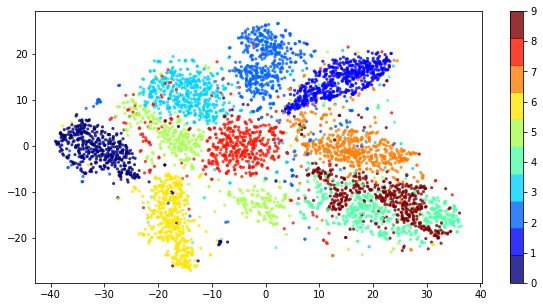

In [21]:
plt.figure(figsize=(10,5))
plt.scatter(tsne_result[:5000, 0], tsne_result[:5000, 1], c=y_test[:5000], edgecolor='none', alpha=0.8,
            cmap=plt.get_cmap('jet', 10), s=10)
plt.colorbar()

In [22]:
random_test = np.random.choice(10000, replace=False, size=5000)

In [23]:
tsne_numbers_embeddings = tsne.fit_transform(numbers_embeddings[random_test])

[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.001s...
[t-SNE] Computed neighbors for 5000 samples in 0.203s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.060696
[t-SNE] KL divergence after 250 iterations with early exaggeration: 58.459812
[t-SNE] Error after 500 iterations: 0.536182


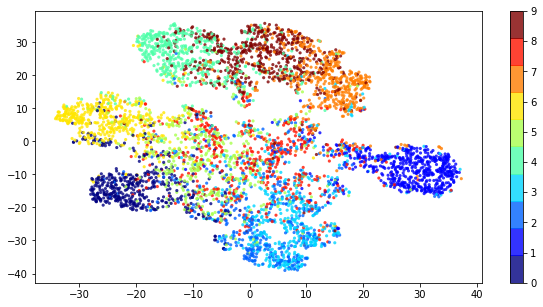

In [24]:
plt.figure(figsize=(10,5))
plt.scatter(tsne_numbers_embeddings[:, 0], tsne_numbers_embeddings[:, 1], c=y_test[random_test], edgecolor='none', alpha=0.8,
            cmap=plt.get_cmap('jet', 10), s=10)
plt.colorbar()